In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
sns.set(rc={'figure.figsize': (20,8)})

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import (StandardScaler, MinMaxScaler)

from sklearn.pipeline import Pipeline

from sklearn.linear_model import (LinearRegression, Lasso, Ridge, ElasticNet)

from sklearn.metrics import mean_squared_error

pd.options.display.float_format = "{:,.4f}".format
pd.set_option('display.max_columns', 100)

/var/folders/7q/6sr3f8p154zcxjkx38dw3tfc0000gn/T/ipykernel_6806/562529077.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
df = pd.read_csv('niftyindex.csv', index_col=0, dayfirst=True)

df

,Open,High,Low,Close,Volume
02/01/2012,"4,640.2000","4,645.9500","4,588.0500","4,636.7500",108461000
03/01/2012,"4,675.8000","4,773.1000","4,675.8000","4,765.3000",146621008
04/01/2012,"4,774.9500","4,782.8500","4,728.8500","4,749.6500",165939008
05/01/2012,"4,749.0000","4,779.8000","4,730.1500","4,749.9500",177863008
06/01/2012,"4,724.1500","4,794.9000","4,686.8500","4,754.1000",176057008
...,...,...,...,...,...
26/12/2022,"17,830.4000","18,084.1000","17,774.2500","18,014.6000",176652336
27/12/2022,"18,089.8000","18,149.2500","17,967.4500","18,132.3000",214257088
28/12/2022,"18,084.7500","18,173.1000","18,068.3500","18,122.5000",193873168
29/12/2022,"18,045.7000","18,229.7000","17,992.8000","18,191.0000",281052832


In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,"2,719.0000","10,124.8980","3,709.6071","4,640.2000","7,637.0000","9,376.9500","11,700.8500","18,871.9500"
High,"2,719.0000","10,175.2921","3,725.5270","4,645.9500","7,681.0000","9,431.9000","11,755.1250","18,887.6000"
Low,"2,719.0000","10,057.4698","3,685.3052","4,588.0500","7,581.6500","9,301.3500","11,631.3250","18,778.2000"
Close,"2,719.0000","10,117.5710","3,706.9455","4,636.7500","7,623.8000","9,351.8500","11,684.0000","18,812.5000"
Volume,"2,719.0000","289,222,065.6433","195,276,778.8519","2,826,000.0000","159,178,008.0000","219,496,064.0000","340,908,832.0000","1,810,971,008.0000"


In [4]:
df.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [5]:
def create_features(frame):
    df = frame.copy()
    multiplier = 2
    
    df['OC'] = df['Close'] / df['Open'] - 1
    df['HC'] = df['High'] / df['Low'] - 1
    df['GAP'] = df['Open'] / df['Close'].shift(1) - 1
    df['RET'] = np.log(df['Close'] / df['Close'].shift(1))
    
    for i in [7, 14, 28]:
        df['PCHG' + str(i)] = df['Close'].pct_change(i)
        df['VCHG' + str(i)] = df['Volume'].pct_change(i)
        df['RET' + str(i)] = df['RET']. rolling(i).sum()
        df['MA' + str(i)] = df['Close'] / df['Close'].rolling(i).mean()
        df['VMA' + str(i)] = df['Volume'] / df['Volume'].rolling(i).mean()
        df['OC' + str(i)] = df['OC'].rolling(i).mean()
        df['HC' + str(i)] = df['HC'].rolling(i).mean()
        df['GAP' + str(i)] = df['GAP'].rolling(i).mean()
        df['STD' + str(i)] = df['RET'].rolling(i).mean()
        df['UB' + str(i)] = df['Close'].rolling(i).mean() + df['Close'].rolling(i).std() * multiplier
        df['LB' + str(i)] = df['Close'].rolling(i).mean() + df['Close'].rolling(i).std() * multiplier
        
    df['Label'] = df['Close'].shift(-1)
    df.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
    df.dropna(inplace=True)
    return df

In [6]:
df1 = create_features(df)
display(df1.shape)

df1

(2690, 38)

,OC,HC,GAP,RET,PCHG7,VCHG7,RET7,MA7,VMA7,OC7,HC7,GAP7,STD7,UB7,LB7,PCHG14,VCHG14,RET14,MA14,VMA14,OC14,HC14,GAP14,STD14,UB14,LB14,PCHG28,VCHG28,RET28,MA28,VMA28,OC28,HC28,GAP28,STD28,UB28,LB28,Label
10/02/2012,-0.0034,0.0162,-0.0023,-0.0057,0.0279,-0.0406,0.0275,1.0058,0.9455,0.0008,0.0145,0.0032,0.0039,"5,442.1990","5,442.1990",0.0660,0.0195,0.0639,1.0249,1.0192,0.0020,0.0142,0.0026,0.0046,"5,486.1450","5,486.1450",0.1606,1.0777,0.1490,1.0646,1.0967,0.0029,0.0138,0.0024,0.0053,"5,509.5275","5,509.5275","5,390.2000"
13/02/2012,0.0015,0.0130,0.0001,0.0016,0.0228,-0.4628,0.0226,1.0042,0.8406,0.0011,0.0146,0.0022,0.0032,"5,428.6264","5,428.6264",0.0682,0.1478,0.0659,1.0217,0.8150,0.0018,0.0146,0.0030,0.0047,"5,489.4954","5,489.4954",0.1311,0.2383,0.1232,1.0616,0.8783,0.0023,0.0135,0.0022,0.0044,"5,534.1504","5,534.1504","5,416.0500"
14/02/2012,0.0066,0.0093,-0.0017,0.0048,0.0169,-0.0734,0.0168,1.0066,0.9424,0.0006,0.0138,0.0018,0.0024,"5,438.1094","5,438.1094",0.0563,-0.0030,0.0548,1.0226,0.9043,0.0014,0.0140,0.0026,0.0039,"5,504.1623","5,504.1623",0.1403,0.2138,0.1313,1.0617,0.9683,0.0027,0.0134,0.0020,0.0047,"5,556.5167","5,556.5167","5,531.9500"
15/02/2012,0.0131,0.0149,0.0082,0.0212,0.0318,0.4616,0.0313,1.0235,1.3794,0.0030,0.0143,0.0015,0.0045,"5,529.6862","5,529.6862",0.0724,0.4343,0.0699,1.0393,1.3696,0.0022,0.0145,0.0028,0.0050,"5,549.6900","5,549.6900",0.1646,0.7675,0.1524,1.0785,1.4768,0.0032,0.0136,0.0023,0.0054,"5,590.9195","5,590.9195","5,521.9500"
16/02/2012,0.0015,0.0087,-0.0033,-0.0018,0.0350,0.4904,0.0344,1.0166,1.1224,0.0053,0.0131,-0.0003,0.0049,"5,566.1259","5,566.1259",0.0610,0.2507,0.0592,1.0330,1.1571,0.0025,0.0143,0.0018,0.0042,"5,584.5662","5,584.5662",0.1615,0.5339,0.1497,1.0708,1.2490,0.0030,0.0131,0.0024,0.0053,"5,617.1127","5,617.1127","5,564.3000"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23/12/2022,-0.0095,0.0152,-0.0083,-0.0178,-0.0457,0.0645,-0.0468,0.9767,1.1157,-0.0050,0.0132,-0.0017,-0.0067,"18,669.0039","18,669.0039",-0.0478,-0.2321,-0.0490,0.9674,1.1010,-0.0025,0.0102,-0.0010,-0.0035,"18,884.8567","18,884.8567",-0.0324,-0.1175,-0.0330,0.9652,1.0284,-0.0009,0.0090,-0.0003,-0.0012,"18,897.5554","18,897.5554","18,014.6000"
26/12/2022,0.0103,0.0174,0.0013,0.0116,-0.0217,-0.0354,-0.0220,0.9912,0.8942,-0.0020,0.0136,-0.0011,-0.0031,"18,604.7406","18,604.7406",-0.0337,-0.1888,-0.0343,0.9811,0.8913,-0.0019,0.0111,-0.0005,-0.0024,"18,862.0702","18,862.0702",-0.0215,-0.1944,-0.0217,0.9772,0.8262,-0.0005,0.0094,-0.0002,-0.0008,"18,912.5171","18,912.5171","18,132.3000"
27/12/2022,0.0023,0.0101,0.0042,0.0065,-0.0075,-0.2283,-0.0075,0.9987,1.1366,-0.0013,0.0136,0.0002,-0.0011,"18,577.5673","18,577.5673",-0.0231,0.0686,-0.0233,0.9891,1.0757,-0.0014,0.0113,-0.0002,-0.0017,"18,831.5918","18,831.5918",-0.0115,0.0685,-0.0116,0.9840,0.9997,-0.0004,0.0096,0.0000,-0.0004,"18,917.4765","18,917.4765","18,122.5000"
28/12/2022,0.0021,0.0058,-0.0026,-0.0005,-0.0162,0.2520,-0.0163,1.0005,0.9989,-0.0020,0.0129,-0.0003,-0.0023,"18,464.3870","18,464.3870",-0.0262,-0.0441,-0.0265,0.9905,0.9765,-0.0014,0.0114,-0.0004,-0.0019,"18,781.0520","18,781.0520",-0.0101,-0.0248,-0.0102,0.9838,0.9054,-0.0002,0.0094,-0.0001,-0.0004,"18,922.4318","18,922.4318","18,191.0000"


In [7]:
y = np.array(df1['Label'])
y

array([ 5390.2 ,  5416.05,  5531.95, ..., 18122.5 , 18191.  , 18105.3 ])

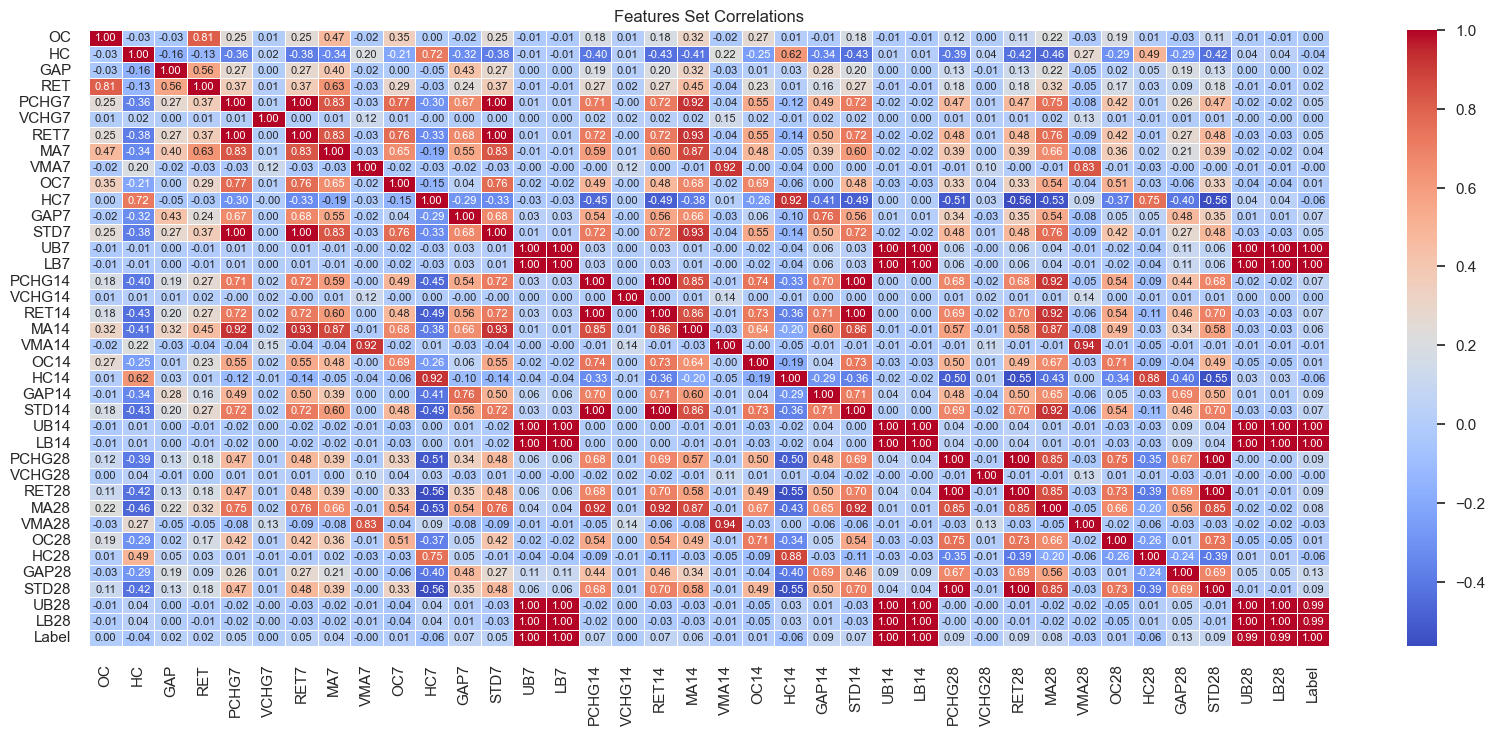

In [8]:
sns.heatmap(df1.corr(),
           annot=True,
           annot_kws={"size":8},
           fmt=".2f",
           linewidth=.5,
           cmap="coolwarm",
           cbar=True);

plt.title('Features Set Correlations');

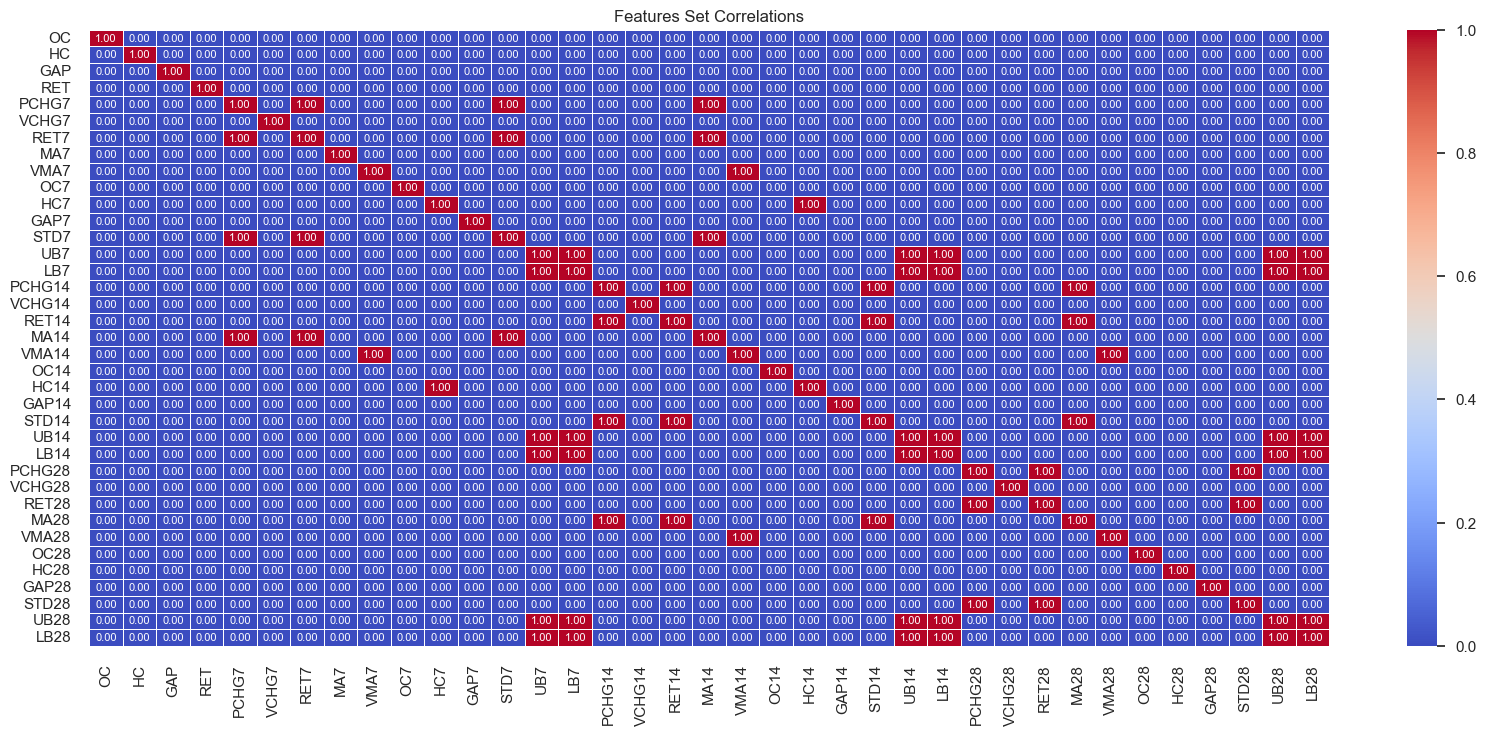

In [9]:
df1.drop('Label', axis=1, inplace=True)

sns.heatmap(df1.corr()>0.9,
           annot=True,
           annot_kws={"size":8},
           fmt=".2f",
           linewidth=.5,
           cmap="coolwarm",
           cbar=True);

plt.title('Features Set Correlations');

In [10]:
def correlated_features(data, threshold=0.9):
    col_corr = set()
    corr_matrix = df1.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

In [11]:
drop_correlated_features = correlated_features(df1)
print(drop_correlated_features)

X = df1.drop(drop_correlated_features, axis=1)

feature_names = X.columns

{'HC14', 'VMA14', 'MA14', 'LB14', 'RET28', 'MA28', 'STD7', 'LB7', 'UB28', 'STD28', 'RET7', 'UB14', 'LB28', 'VMA28', 'STD14', 'RET14'}


In [12]:
X

,OC,HC,GAP,RET,PCHG7,VCHG7,MA7,VMA7,OC7,HC7,GAP7,UB7,PCHG14,VCHG14,OC14,GAP14,PCHG28,VCHG28,OC28,HC28,GAP28
10/02/2012,-0.0034,0.0162,-0.0023,-0.0057,0.0279,-0.0406,1.0058,0.9455,0.0008,0.0145,0.0032,"5,442.1990",0.0660,0.0195,0.0020,0.0026,0.1606,1.0777,0.0029,0.0138,0.0024
13/02/2012,0.0015,0.0130,0.0001,0.0016,0.0228,-0.4628,1.0042,0.8406,0.0011,0.0146,0.0022,"5,428.6264",0.0682,0.1478,0.0018,0.0030,0.1311,0.2383,0.0023,0.0135,0.0022
14/02/2012,0.0066,0.0093,-0.0017,0.0048,0.0169,-0.0734,1.0066,0.9424,0.0006,0.0138,0.0018,"5,438.1094",0.0563,-0.0030,0.0014,0.0026,0.1403,0.2138,0.0027,0.0134,0.0020
15/02/2012,0.0131,0.0149,0.0082,0.0212,0.0318,0.4616,1.0235,1.3794,0.0030,0.0143,0.0015,"5,529.6862",0.0724,0.4343,0.0022,0.0028,0.1646,0.7675,0.0032,0.0136,0.0023
16/02/2012,0.0015,0.0087,-0.0033,-0.0018,0.0350,0.4904,1.0166,1.1224,0.0053,0.0131,-0.0003,"5,566.1259",0.0610,0.2507,0.0025,0.0018,0.1615,0.5339,0.0030,0.0131,0.0024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23/12/2022,-0.0095,0.0152,-0.0083,-0.0178,-0.0457,0.0645,0.9767,1.1157,-0.0050,0.0132,-0.0017,"18,669.0039",-0.0478,-0.2321,-0.0025,-0.0010,-0.0324,-0.1175,-0.0009,0.0090,-0.0003
26/12/2022,0.0103,0.0174,0.0013,0.0116,-0.0217,-0.0354,0.9912,0.8942,-0.0020,0.0136,-0.0011,"18,604.7406",-0.0337,-0.1888,-0.0019,-0.0005,-0.0215,-0.1944,-0.0005,0.0094,-0.0002
27/12/2022,0.0023,0.0101,0.0042,0.0065,-0.0075,-0.2283,0.9987,1.1366,-0.0013,0.0136,0.0002,"18,577.5673",-0.0231,0.0686,-0.0014,-0.0002,-0.0115,0.0685,-0.0004,0.0096,0.0000
28/12/2022,0.0021,0.0058,-0.0026,-0.0005,-0.0162,0.2520,1.0005,0.9989,-0.0020,0.0129,-0.0003,"18,464.3870",-0.0262,-0.0441,-0.0014,-0.0004,-0.0101,-0.0248,-0.0002,0.0094,-0.0001


In [13]:
X.describe()

,OC,HC,GAP,RET,PCHG7,VCHG7,MA7,VMA7,OC7,HC7,GAP7,UB7,PCHG14,VCHG14,OC14,GAP14,PCHG28,VCHG28,OC28,HC28,GAP28
count,"2,690.0000","2,690.0000","2,690.0000","2,690.0000","2,690.0000","2,690.0000","2,690.0000","2,690.0000","2,690.0000","2,690.0000","2,690.0000","2,690.0000","2,690.0000","2,690.0000","2,690.0000","2,690.0000","2,690.0000","2,690.0000","2,690.0000","2,690.0000","2,690.0000"
mean,-0.0007,0.0119,0.0012,0.0005,0.0036,0.1016,1.0014,1.0024,-0.0007,0.0119,0.0012,"10,363.3054",0.0074,0.1658,-0.0007,0.0012,0.0153,0.1229,-0.0007,0.0119,0.0012
std,0.0089,0.0082,0.0063,0.0108,0.0283,1.9471,0.0147,0.2179,0.0030,0.0061,0.0026,"3,755.5770",0.0405,4.8659,0.0021,0.0020,0.0566,2.2287,0.0015,0.0050,0.0014
min,-0.0682,0.0025,-0.0914,-0.1390,-0.2294,-0.9925,0.8703,0.0094,-0.0159,0.0050,-0.0287,"4,937.6487",-0.3164,-0.9904,-0.0108,-0.0205,-0.3675,-0.9919,-0.0072,0.0059,-0.0100
25%,-0.0051,0.0073,-0.0010,-0.0046,-0.0119,-0.1811,0.9930,0.8633,-0.0025,0.0087,0.0002,"7,849.8332",-0.0138,-0.1996,-0.0018,0.0004,-0.0164,-0.2094,-0.0015,0.0091,0.0005
50%,-0.0005,0.0100,0.0015,0.0007,0.0053,0.0021,1.0029,0.9701,-0.0006,0.0107,0.0013,"9,681.1755",0.0092,-0.0056,-0.0006,0.0013,0.0187,-0.0117,-0.0006,0.0110,0.0013
75%,0.0039,0.0139,0.0039,0.0062,0.0198,0.2130,1.0103,1.1034,0.0012,0.0136,0.0024,"11,955.6179",0.0312,0.2298,0.0006,0.0022,0.0513,0.2552,0.0003,0.0134,0.0020
max,0.0931,0.1875,0.0448,0.0840,0.1463,98.2647,1.0654,2.4288,0.0140,0.0904,0.0156,"18,937.7871",0.1879,251.1766,0.0061,0.0131,0.2088,112.8719,0.0035,0.0536,0.0074


Text(0.5, 1.0, 'Boxplot of Features')

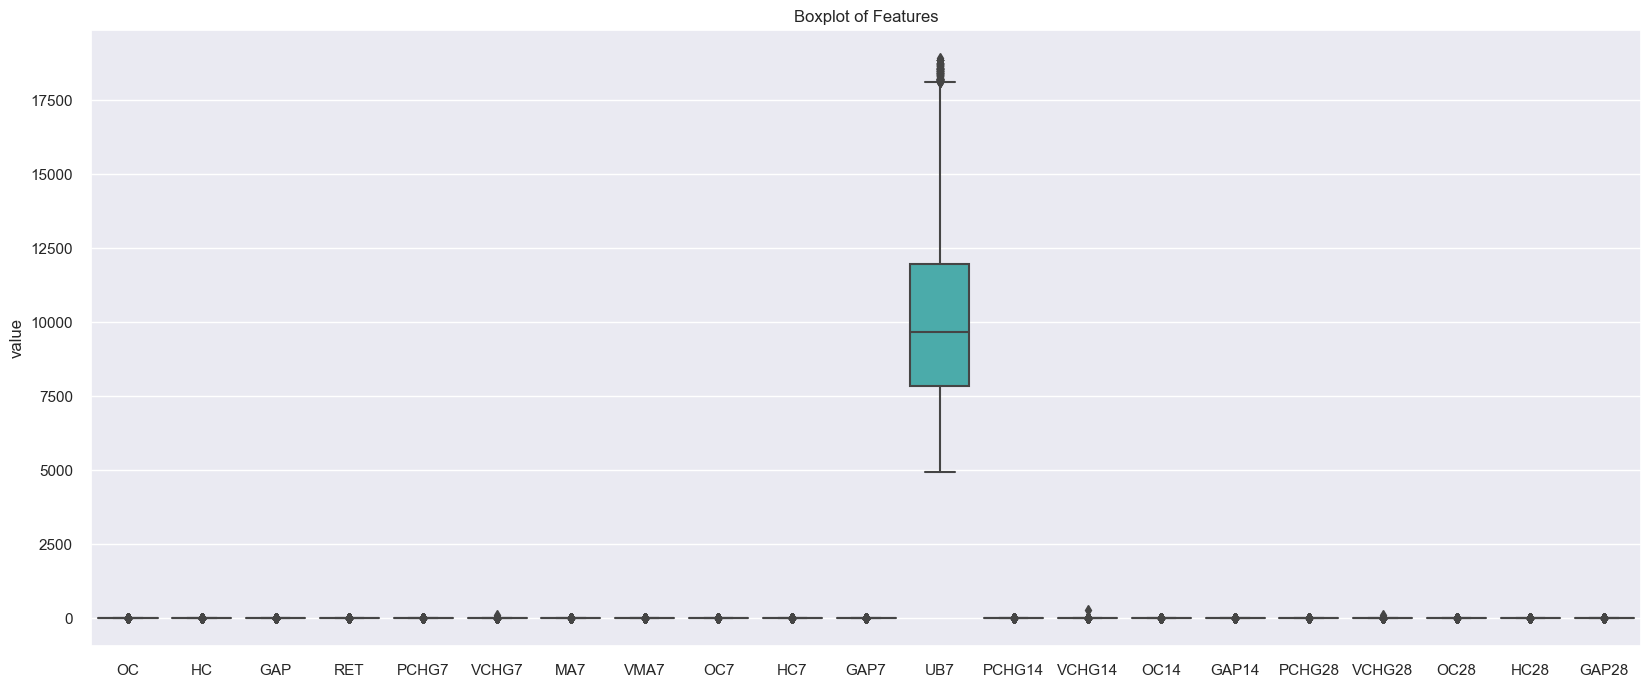

In [14]:
sns.boxplot(x='variable', y='value', data=pd.melt(X))
plt.xlabel('')
plt.title('Boxplot of Features')

In [15]:
class Regression:
    
    def __init__(self, X, y, testsize=0.20):
        
        self.X = X
        self.y = y
        self.testsize = testsize
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, 
                                                                                self.y, 
                                                                                test_size=self.testsize, 
                                                                                shuffle=False)
        
    def fit_predict(self, estimator, transformer, alpha=None, 
                    l1_ratio=None):
            
        try:
            model = Pipeline([('scaler', transformer), 
                              ('regressor', estimator)])
                
            model.fit(self.X_train, self.y_train)
                
            y_pred = model.predict(self.X_test)
                
        except Exception as e:
            print(str(e))
                
        return model, model['regressor'].intercept_, model['regressor'].coef_, y_pred, self.y_test
        
    def eval_metrics(self, model, y_pred):
        
        mse = mean_squared_error(self.y_test, y_pred, squared=True)
        rmse = mean_squared_error(self.y_test, y_pred, squared=False)
        r2train = model.score(self.X_train, self.y_train)
        r2test = model.score(self.X_test, self.y_test)
        
        return mse, rmse, r2train, r2test
    
    def plot_coeff(self, modelname):
        
        coef = []
        model = Regression(self.X, self.y, 0.20)
        alpha_range = np.logspace(2, -2, 200)
        
        if modelname == 'Lasso':
            for i in alpha_range:
                coef.append(model.fit_predict(Lasso(alpha=i, 
                                                   random_state=0), 
                                             MinMaxScaler())[2])
                
        elif modelname == 'Ridge':
            alpha_range = np.logspace(6, -2, 200)
            for i in alpha_range:
                coef.append(model.fit_predict(Ridge(alpha=i, 
                                                   random_state=0),
                                             MinMaxScaler())[2])
                
        elif modelname == 'ElasticNet':
            for i in alpha_range:
                coef.append(model.fit_predict(ElasticNet(alpha=i, 
                                                   random_state=0),
                                             MinMaxScaler())[2])
                
        fig = plt.figure(figsize=(20,8))
        ax = plt.axes()
        
        ax.plot(alpha_range, coef)
        ax.set_xscale('log')
        ax.legend(feature_names, loc=0)
        
        ax.set_title(f'{modelname}coefficients as function of the regularization')
        ax.set_xlabel('$\lambda$')
        ax.set_ylabel('$\mathbf{w}$')
        
        return plt.show()
                        

In [16]:
lr = Regression(X, y)

lr_model, lr_intercept, lr_coef, lr_y_pred,lr_y_test = lr.fit_predict(LinearRegression(),
                                                           MinMaxScaler())

print(f"\n Model: {lr_model} \n Intercept: {lr_intercept} \n Coefficients: {lr_coef}")


 Model: Pipeline(steps=[('scaler', MinMaxScaler()), ('regressor', LinearRegression())]) 
 Intercept: 3696.255390953216 
 Coefficients: [-18169.26660927     83.89239844 -15445.65154269  25282.83396413
 -17356.18879994   -138.02253581   1507.30389742    -65.57402353
   9515.24067169  -1574.59897669  14425.09755659   7403.74974726
   2778.39351642     31.399475    -1245.46962796  -2321.4158295
   3798.6355412     -36.44872847  -2001.28868912    172.78424285
  -3235.45219031]


In [17]:
lr_y_pred

array([11641.60423745, 11641.84674759, 11679.83159684, 11812.61348246,
       12096.85451512, 12325.55070654, 12592.48016259, 12790.80811162,
       12897.74996971, 12882.93011965, 12845.70747491, 12847.45672678,
       12838.89430807, 12889.82030678, 12754.9800024 , 12843.55865266,
       12869.89279296, 13028.90956397, 12801.34378294, 12914.66290791,
       12875.23911134, 12997.59932334, 13020.27577452, 13061.33115493,
       13237.18182425, 13314.65237009, 13427.63782058, 13559.18145403,
       13581.32240663, 13574.92952072, 13538.65331428, 13510.180883  ,
       13623.67102289, 13686.32098791, 13737.93658168, 13387.76840995,
       13515.09282131, 13588.81604493, 13701.84665402, 13837.54753274,
       13934.61491728, 14026.19977035, 13999.46071194, 14026.19906037,
       14060.39468082, 14111.82827246, 14060.06994843, 14043.6121413 ,
       14255.72780236, 14444.17297726, 14536.22518417, 14597.75152748,
       14668.53951851, 14491.87907235, 14312.7411771 , 14447.75049689,
      

In [18]:
lasso = Regression(X, y)

lasso_model, lasso_intercept, lasso_coef, lasso_y_pred, lasso_y_test = lasso.fit_predict(Lasso(alpha=0.3, random_state=0), MinMaxScaler())

print(f"\n Model: {lasso_model} \n Intercept: {lasso_intercept} \n Coefficients:{lasso_coef}")


 Model: Pipeline(steps=[('scaler', MinMaxScaler()),
                ('regressor', Lasso(alpha=0.3, random_state=0))]) 
 Intercept: 3716.5619211496687 
 Coefficients:[ 0.00000000e+00 -2.63489097e+02  0.00000000e+00  3.19135144e+01
 -0.00000000e+00 -0.00000000e+00  1.54453108e+03 -3.90068184e+01
 -6.88848941e+01 -1.13568481e+03  3.24670078e+02  7.39817542e+03
  0.00000000e+00 -0.00000000e+00  4.52846926e+01  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  4.80602626e+00
  0.00000000e+00]


/Users/alexcsoh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.019e+06, tolerance: 9.581e+05
  model = cd_fast.enet_coordinate_descent(
/Users/alexcsoh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.282e+06, tolerance: 9.581e+05
  model = cd_fast.enet_coordinate_descent(
/Users/alexcsoh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

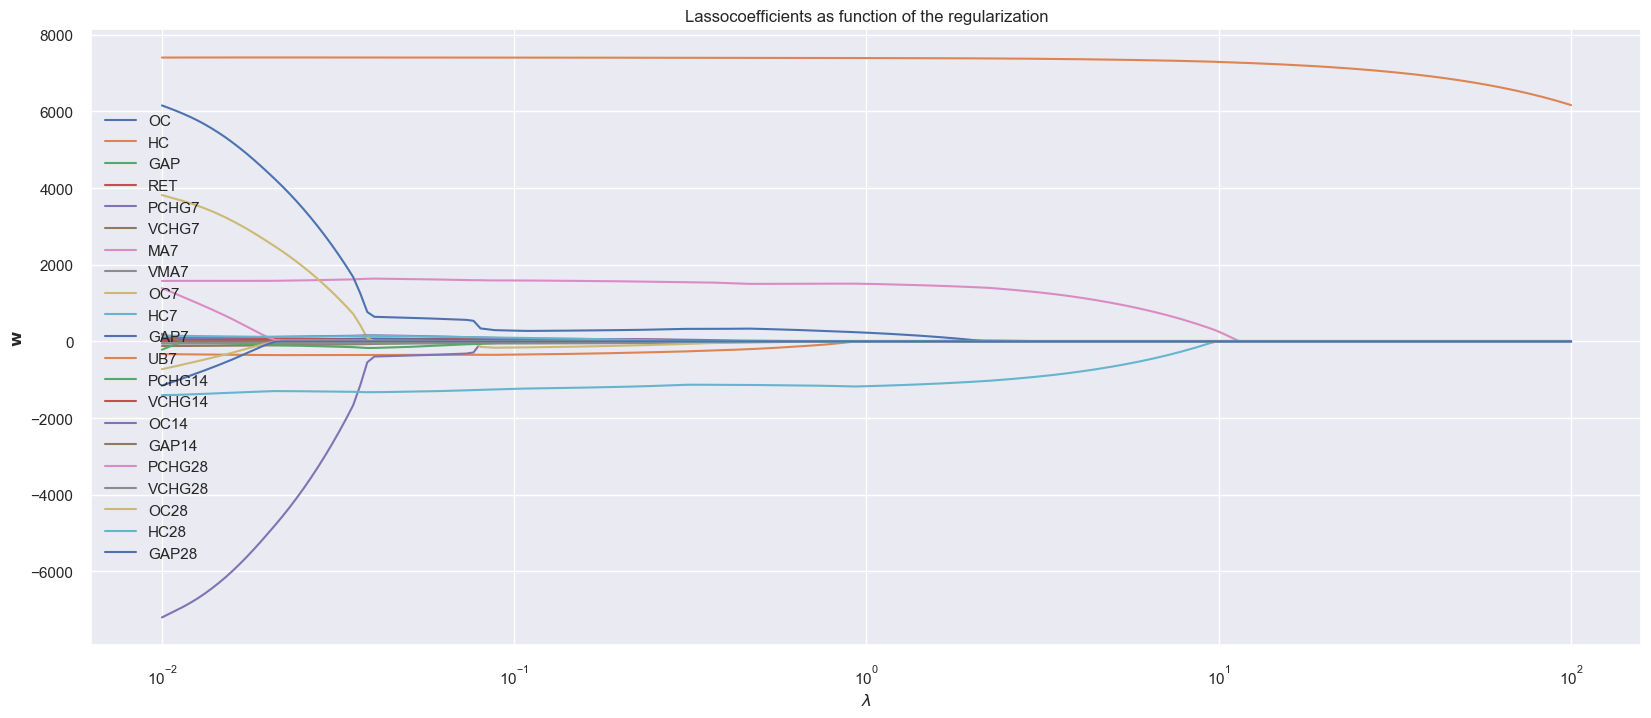

In [19]:
lasso.plot_coeff('Lasso')

In [20]:
ridge = Regression(X, y)

ridge_model , ridge_intercept, ridge_coef, ridge_y_pred, ridge_y_test = ridge.fit_predict(Ridge(alpha=1, random_state=0), MinMaxScaler())

print(f"\n Model: {ridge_model} \n Intercept: {ridge_intercept} \n Coefficients: {ridge_coef}")


 Model: Pipeline(steps=[('scaler', MinMaxScaler()),
                ('regressor', Ridge(alpha=1, random_state=0))]) 
 Intercept: 3557.7606012970728 
 Coefficients: [ 141.67642687 -484.52410403   71.80576828  169.85165159   90.35432303
  -69.30230844 1167.7848332   -44.99609238  -70.40970901 -943.67481373
  453.09083232 7356.53852575  -39.14551341   12.11323995  115.76637243
   81.94314808   29.99137687  -52.62887601   -7.81107809  -20.00098688
   22.43557293]


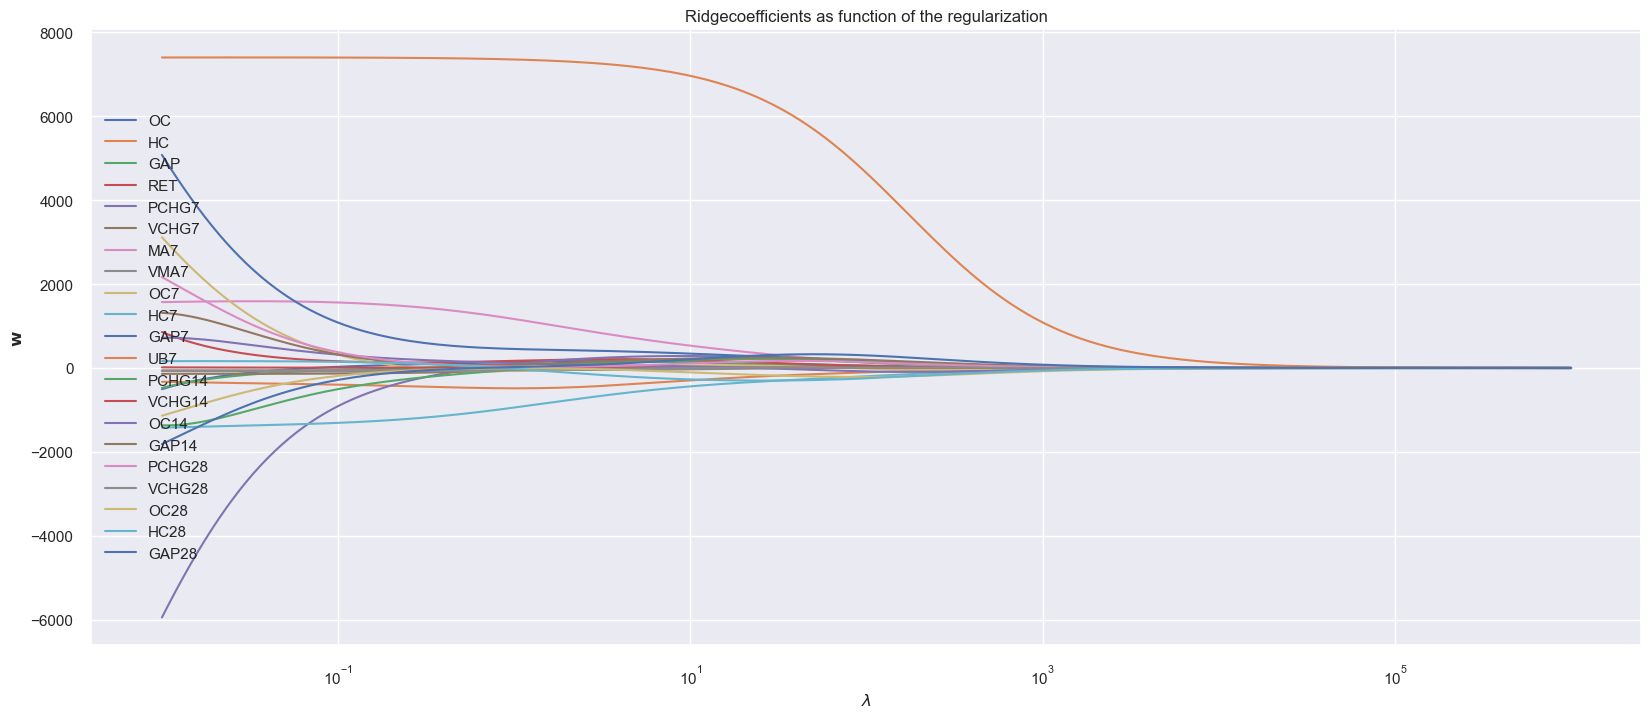

In [21]:
ridge.plot_coeff('Ridge')

In [22]:
elasticnet = Regression(X,y)

elasticnet_model , elasticnet_intercept, elasticnet_coef, elasticnet_y_pred, elasticnet_y_test = elasticnet.fit_predict(ElasticNet(alpha=0.1, l1_ratio=1e-10, random_state=0), MinMaxScaler())

print(f"\n Model: {elasticnet_model} \n Intercept: {elasticnet_intercept} \n Coefficients: \n {elasticnet_coef}")


 Model: Pipeline(steps=[('scaler', MinMaxScaler()),
                ('regressor',
                 ElasticNet(alpha=0.1, l1_ratio=1e-10, random_state=0))]) 
 Intercept: 6623.051561693423 
 Coefficients: 
 [ 1.60882013e+00 -6.38193100e+01  3.65387989e+01  2.39954377e+01
  7.06791006e+01  5.73668831e+00  7.02201669e+01  1.15858431e+01
 -3.98003003e+01 -1.29746280e+02  1.13421240e+02  3.27230143e+03
  8.42511165e+01  6.27248503e+00 -9.23570005e+01  1.38843852e+02
  9.19547936e+01  6.80709354e+00 -1.85863501e+02 -1.77301755e+02
  2.26007457e+02]


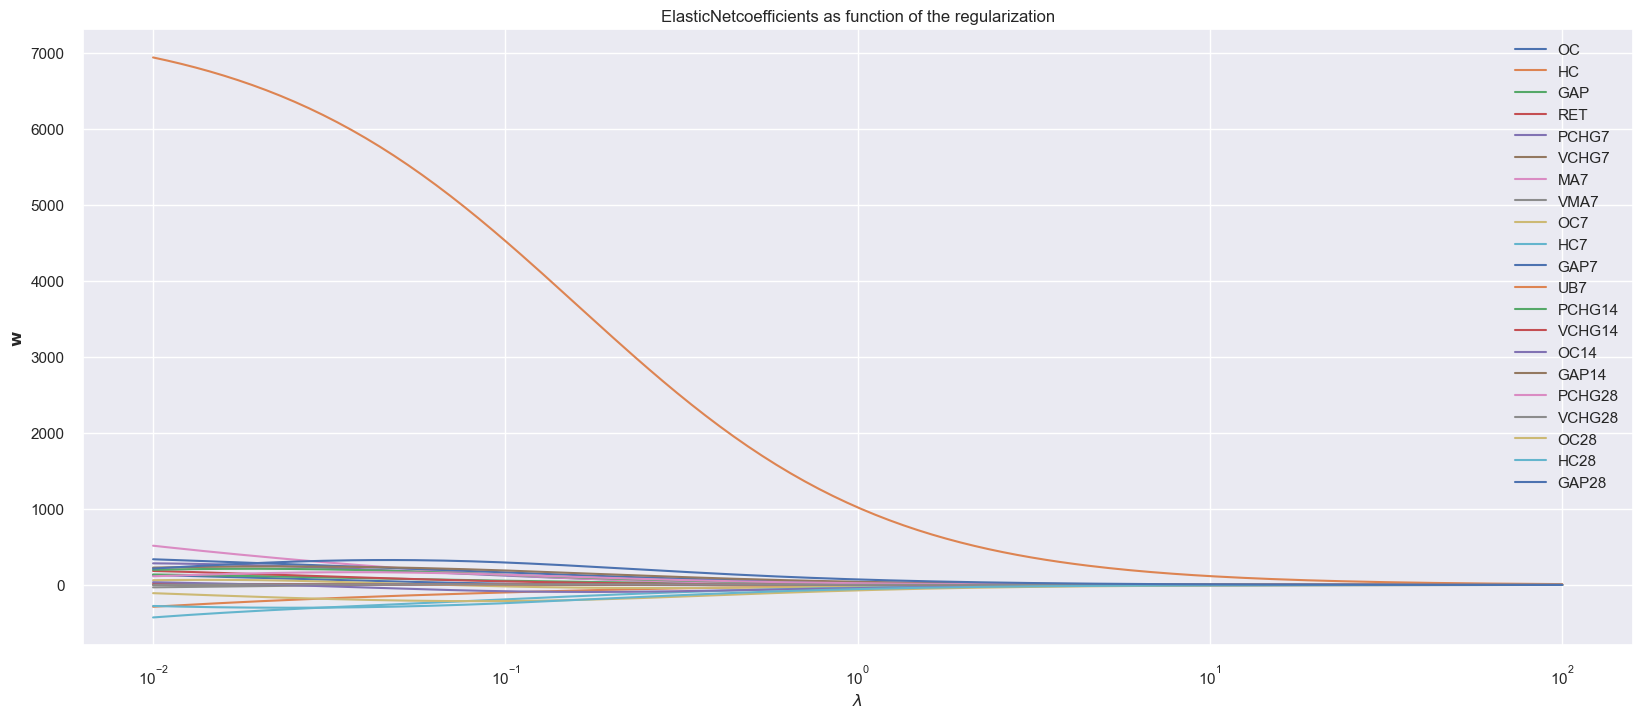

In [23]:
elasticnet.plot_coeff('ElasticNet')

In [24]:
coef_df = pd.DataFrame({
    'LR': lr_coef,
    'Lasso': lasso_coef,
    'Ridge': ridge_coef,
    'ElasticNet': elasticnet_coef
}, index = feature_names)

coef_df

,LR,Lasso,Ridge,ElasticNet
OC,"-18,169.2666",0.0000,141.6764,1.6088
HC,83.8924,-263.4891,-484.5241,-63.8193
GAP,"-15,445.6515",0.0000,71.8058,36.5388
RET,"25,282.8340",31.9135,169.8517,23.9954
PCHG7,"-17,356.1888",-0.0000,90.3543,70.6791
VCHG7,-138.0225,-0.0000,-69.3023,5.7367
MA7,"1,507.3039","1,544.5311","1,167.7848",70.2202
VMA7,-65.5740,-39.0068,-44.9961,11.5858
OC7,"9,515.2407",-68.8849,-70.4097,-39.8003
HC7,"-1,574.5990","-1,135.6848",-943.6748,-129.7463


In [25]:
eval_df = pd.DataFrame({
    'LR': lr.eval_metrics(lr_model, lr_y_pred),
    'Lasso': lasso.eval_metrics(lasso_model, lasso_y_pred),
    'Ridge': ridge.eval_metrics(ridge_model, ridge_y_pred),
    'ElasticNet': elasticnet.eval_metrics(elasticnet_model, elasticnet_y_pred)
}, index = ['MSE', 'RMSE', 'R2_train', 'R2_test'])

eval_df

,LR,Lasso,Ridge,ElasticNet
MSE,"53,624.2933","56,481.0090","60,999.6592","19,568,741.2091"
RMSE,231.5692,237.6573,246.9811,"4,423.6570"
R2_train,0.9968,0.9963,0.9962,0.6903
R2_test,0.9772,0.9759,0.9740,-7.3351


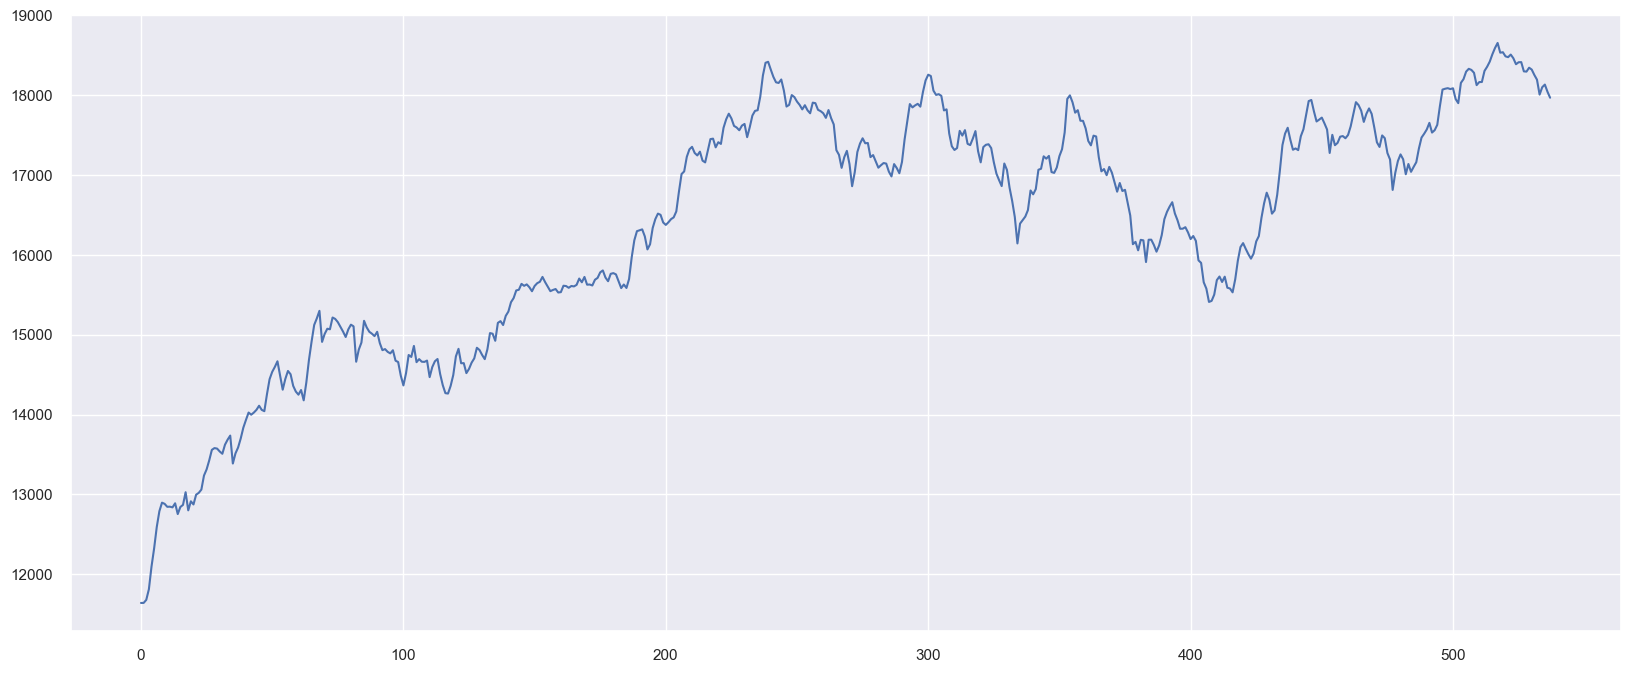

In [26]:
plt.plot(lr_y_pred);

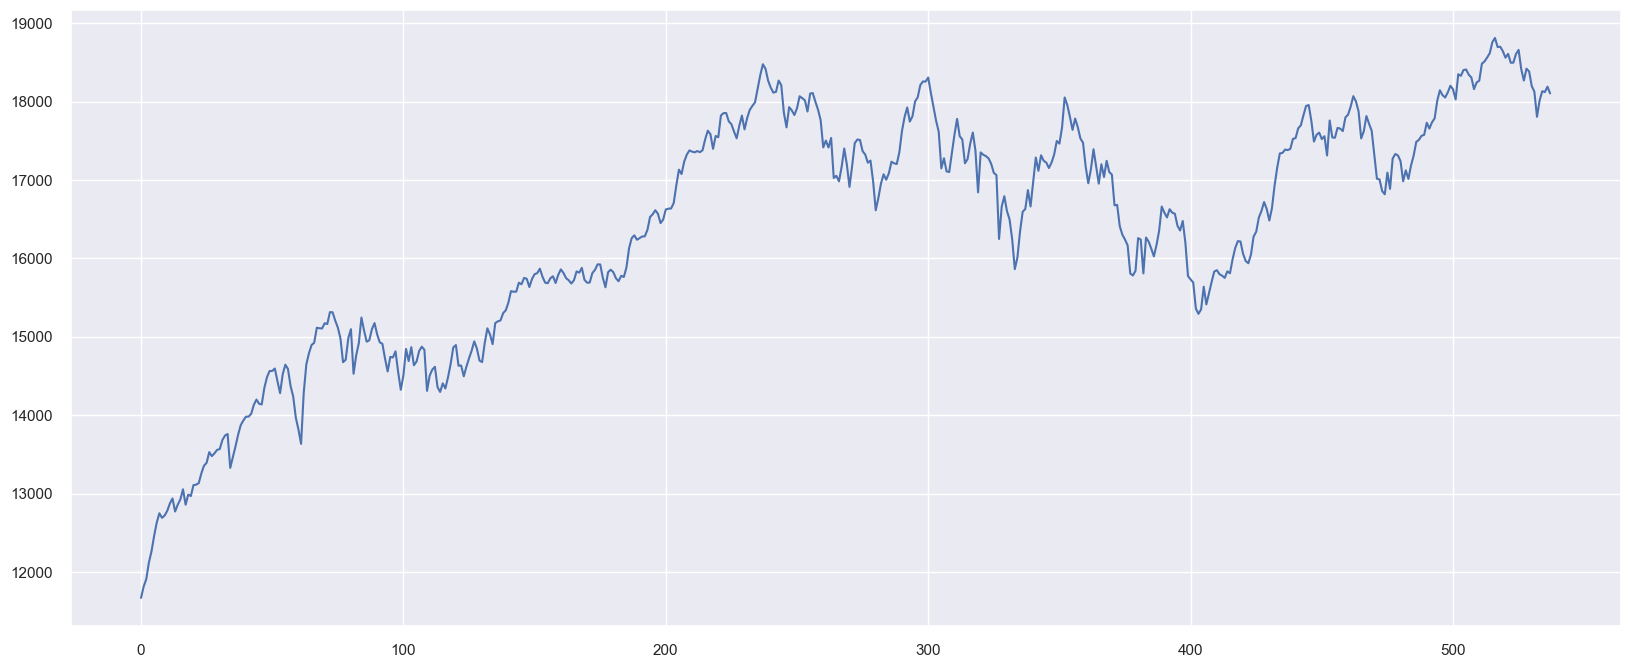

In [27]:
plt.plot(lr_y_test);

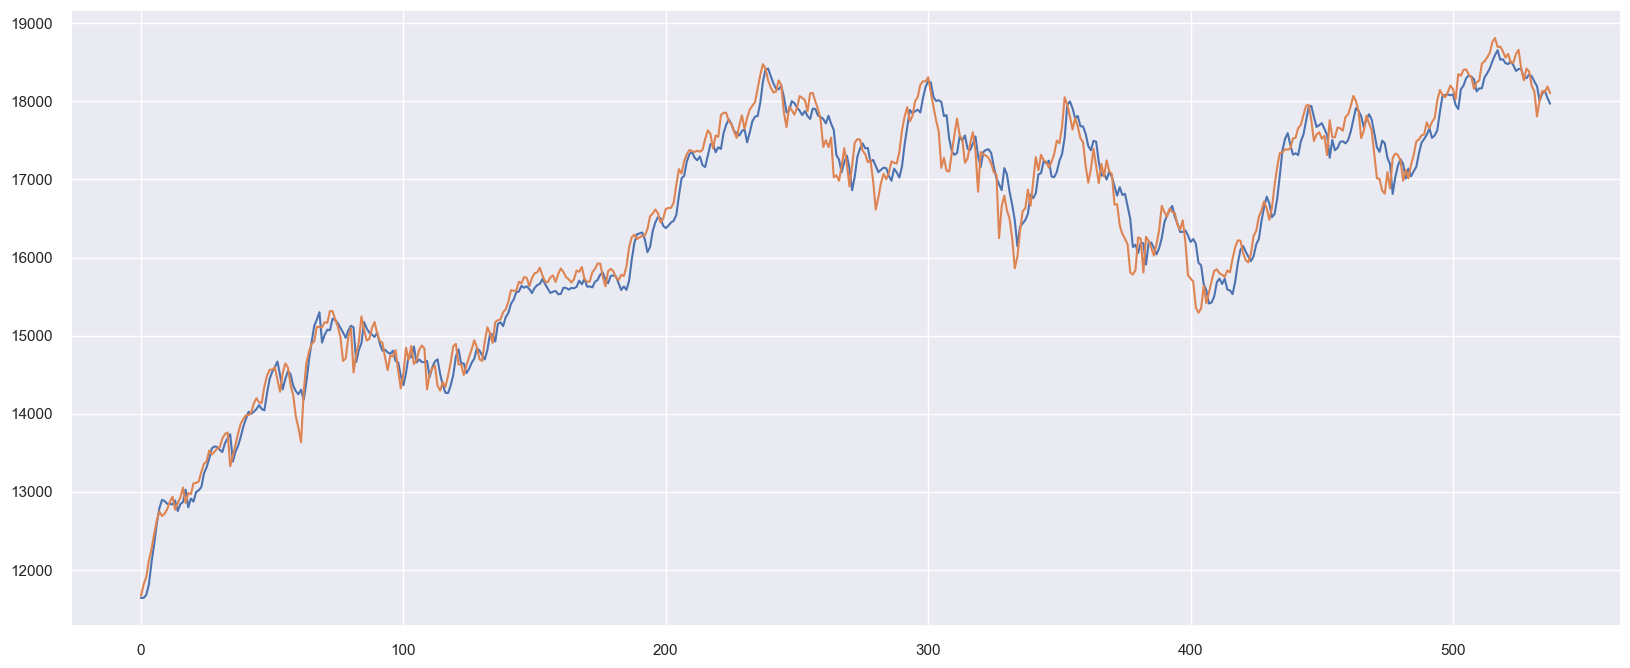

In [28]:
plt.plot(lr_y_pred)
plt.plot(lr_y_test);

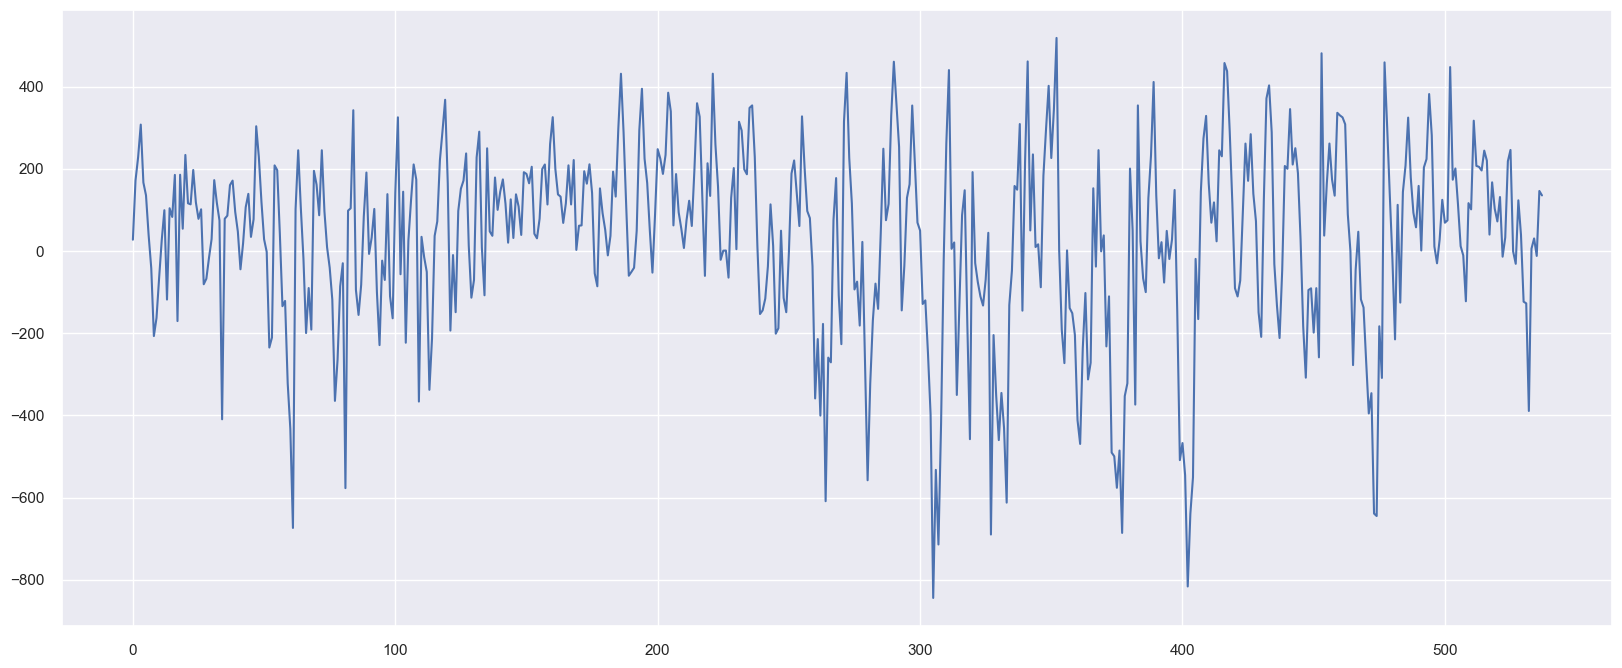

In [29]:
plt.plot(lr_y_test-lr_y_pred);

In [30]:
(lr_y_test-lr_y_pred).mean()

27.808023918845137

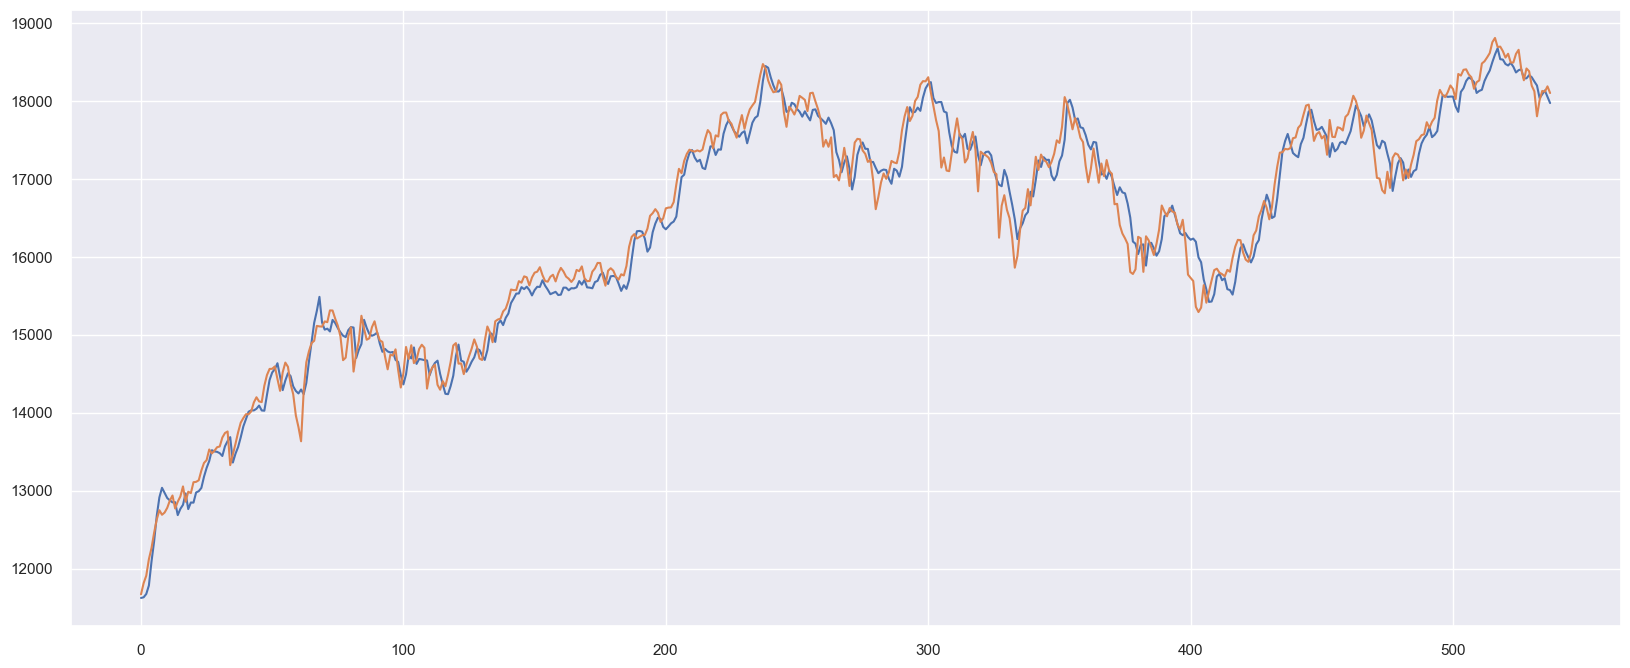

In [31]:
plt.plot(lasso_y_pred)
plt.plot(lasso_y_test);

In [32]:
(lasso_y_test-lasso_y_pred).mean()

34.32942421290436

In [33]:
(lasso_y_test-lasso_y_pred).mean() / lasso_y_test.mean() * 100

0.20983804385551977